In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(batchelor)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

In [47]:
table(sce_complete$celltype)


           B_C01-MS4A1            B_C02-CD79A            CAF_C01-FAP 
                   657                    270                     58 
          CAF_C02-CD36           CD4_C06-IL7R          CD4_C07-FOXP3 
                   435                    388                    106 
      CD4/CD8_C01-LEF1      CD4/CD8_C02-MKI67           CD8_C03-GZMK 
                   412                    115                    512 
       CD8_C04-SLC4A10         CD8_C05-CX3CR1     cHCC_ICC_D20171229 
                   186                    244                    756 
           DC_C01-CD1C          DC_C02-CLEC9A           DC_C03-LAMP3 
                   331                     83                     19 
         DC_C04-CLEC4C          DC_C05-FCER1A          Endo_C01-FMO2 
                    14                     10                    315 
        Endo_C02-CD200        Endo_C03-CXCL12         Endo_C04-ACKR1 
                   268                    188                    149 
         Endo_C05-R

In [10]:
log_info("Reading SCE object...")
sce_complete <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")
log_info("SCE object done")

In [20]:
sce <- sce_complete[, sce_complete$celltype == "HCC_D20171220"]
sce <- logNormCounts(sce)

# Feature Selection

In [22]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep, min.mean = 1, density.weights=TRUE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [23]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [32]:

sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_pca" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$draw_graph(adata_sce)
sc$tl$leiden(adata_sce, resolution = .6)
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [33]:
reducedDim(sce, "PCA") <- reducedDim(sce, "X_pca")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")

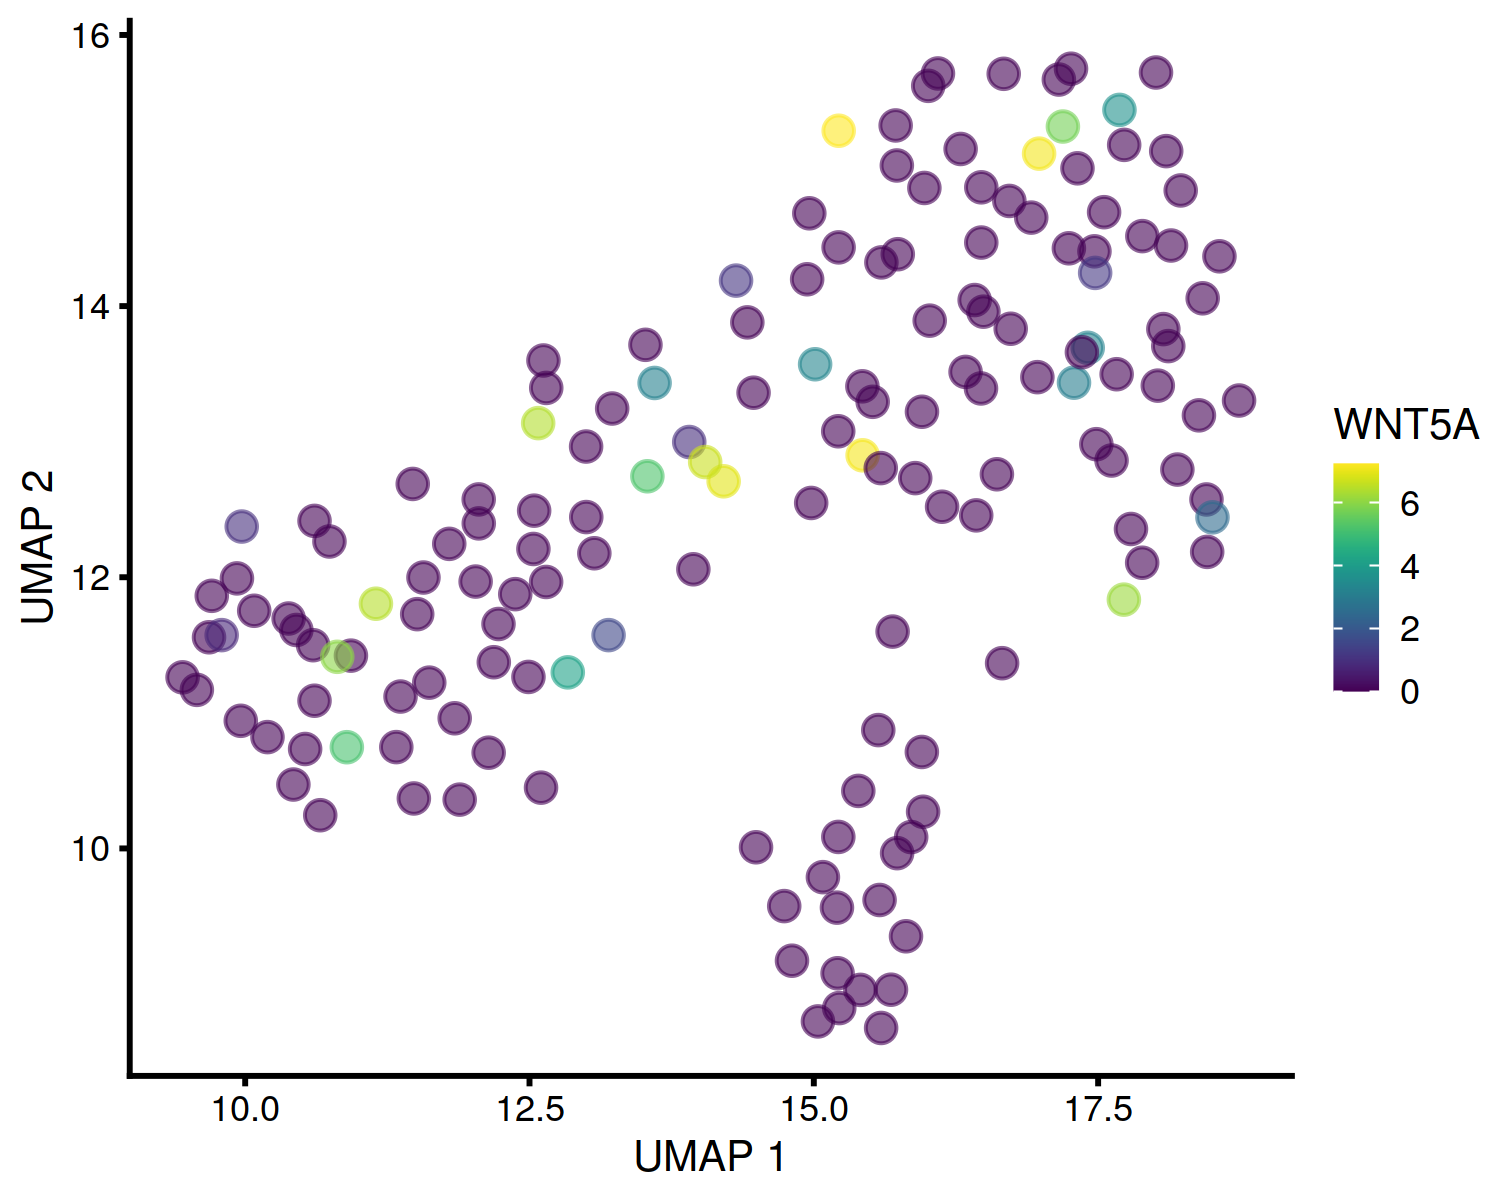

In [45]:
plotUMAP(sce,  colour_by = 'WNT5A', point_size = 3)

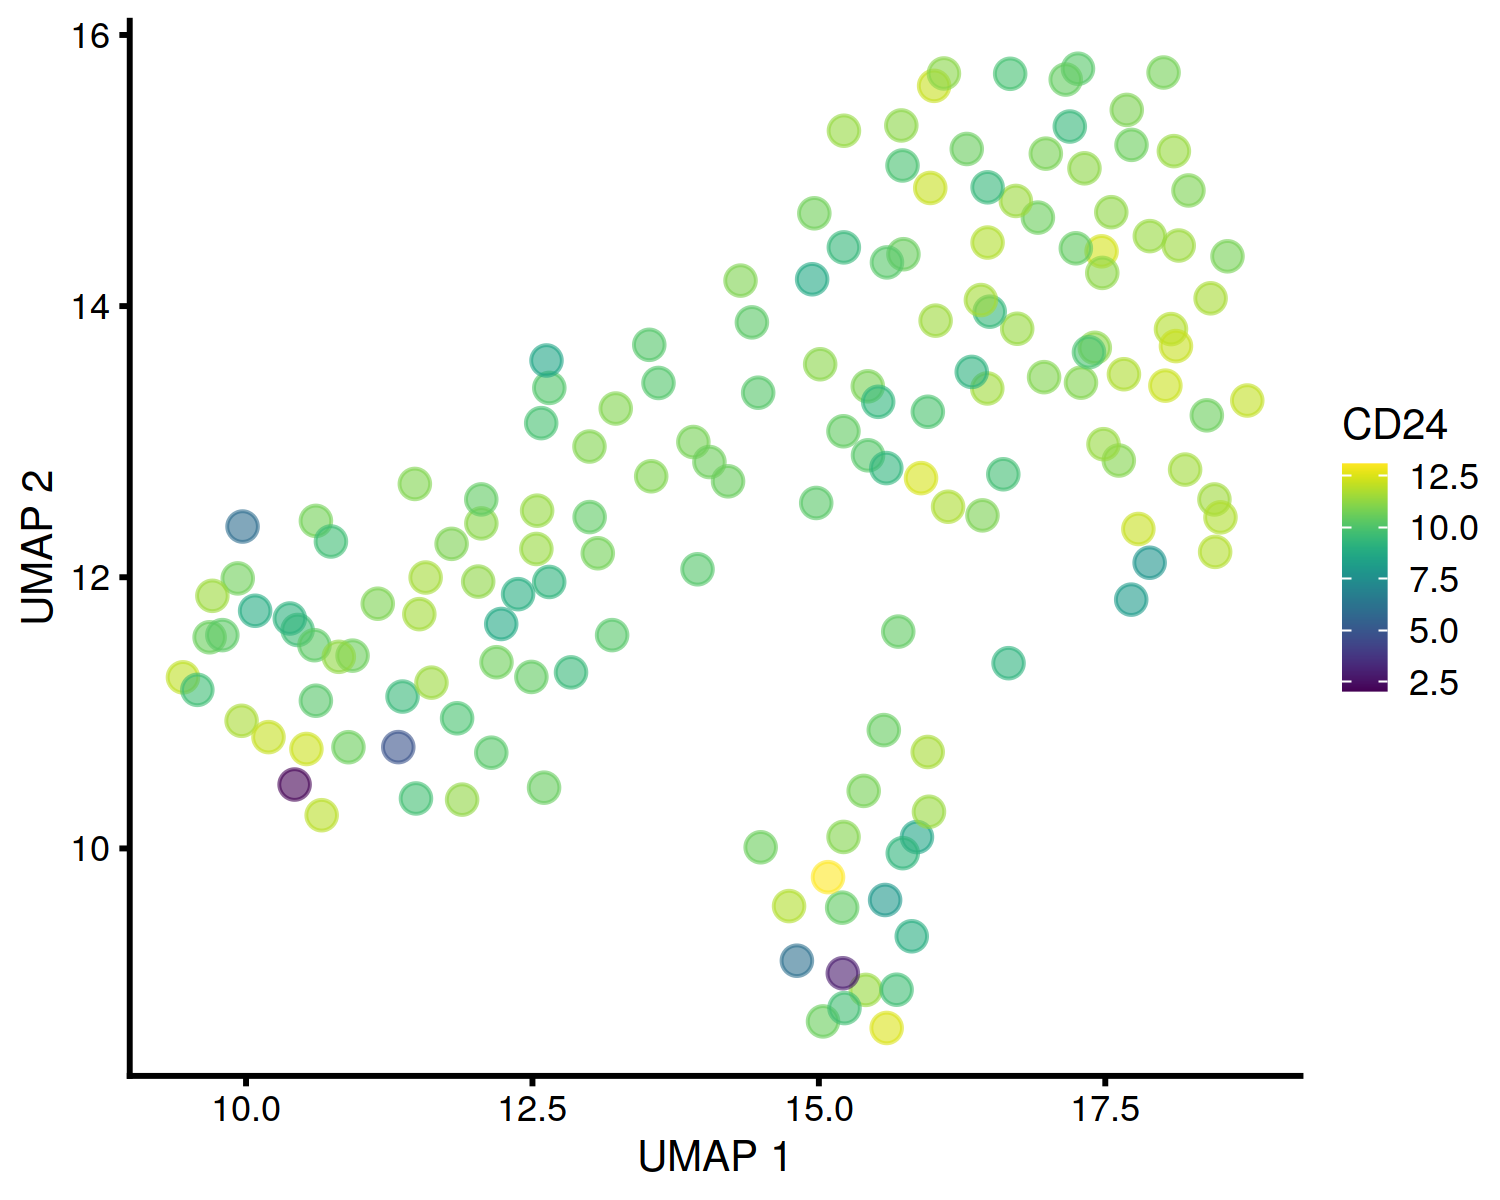

In [46]:
plotUMAP(sce,  colour_by = 'CD24', point_size = 3)

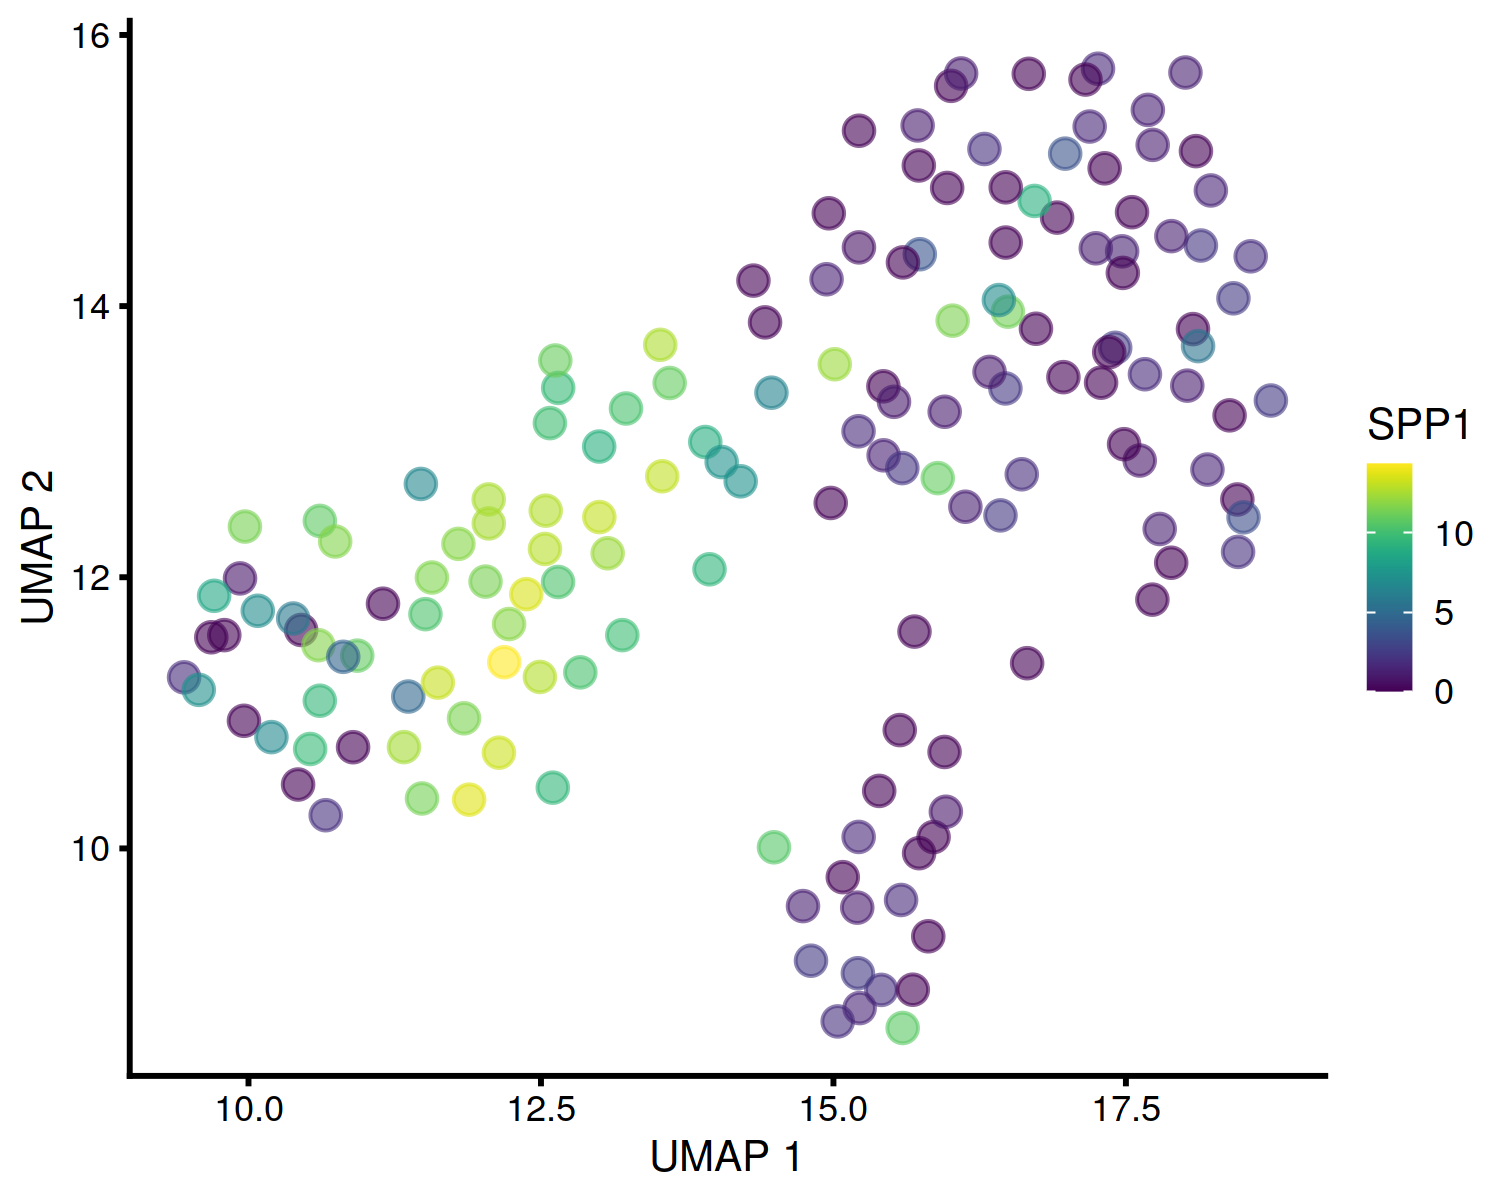

In [41]:
plotUMAP(sce,  colour_by = 'SPP1', point_size = 3)

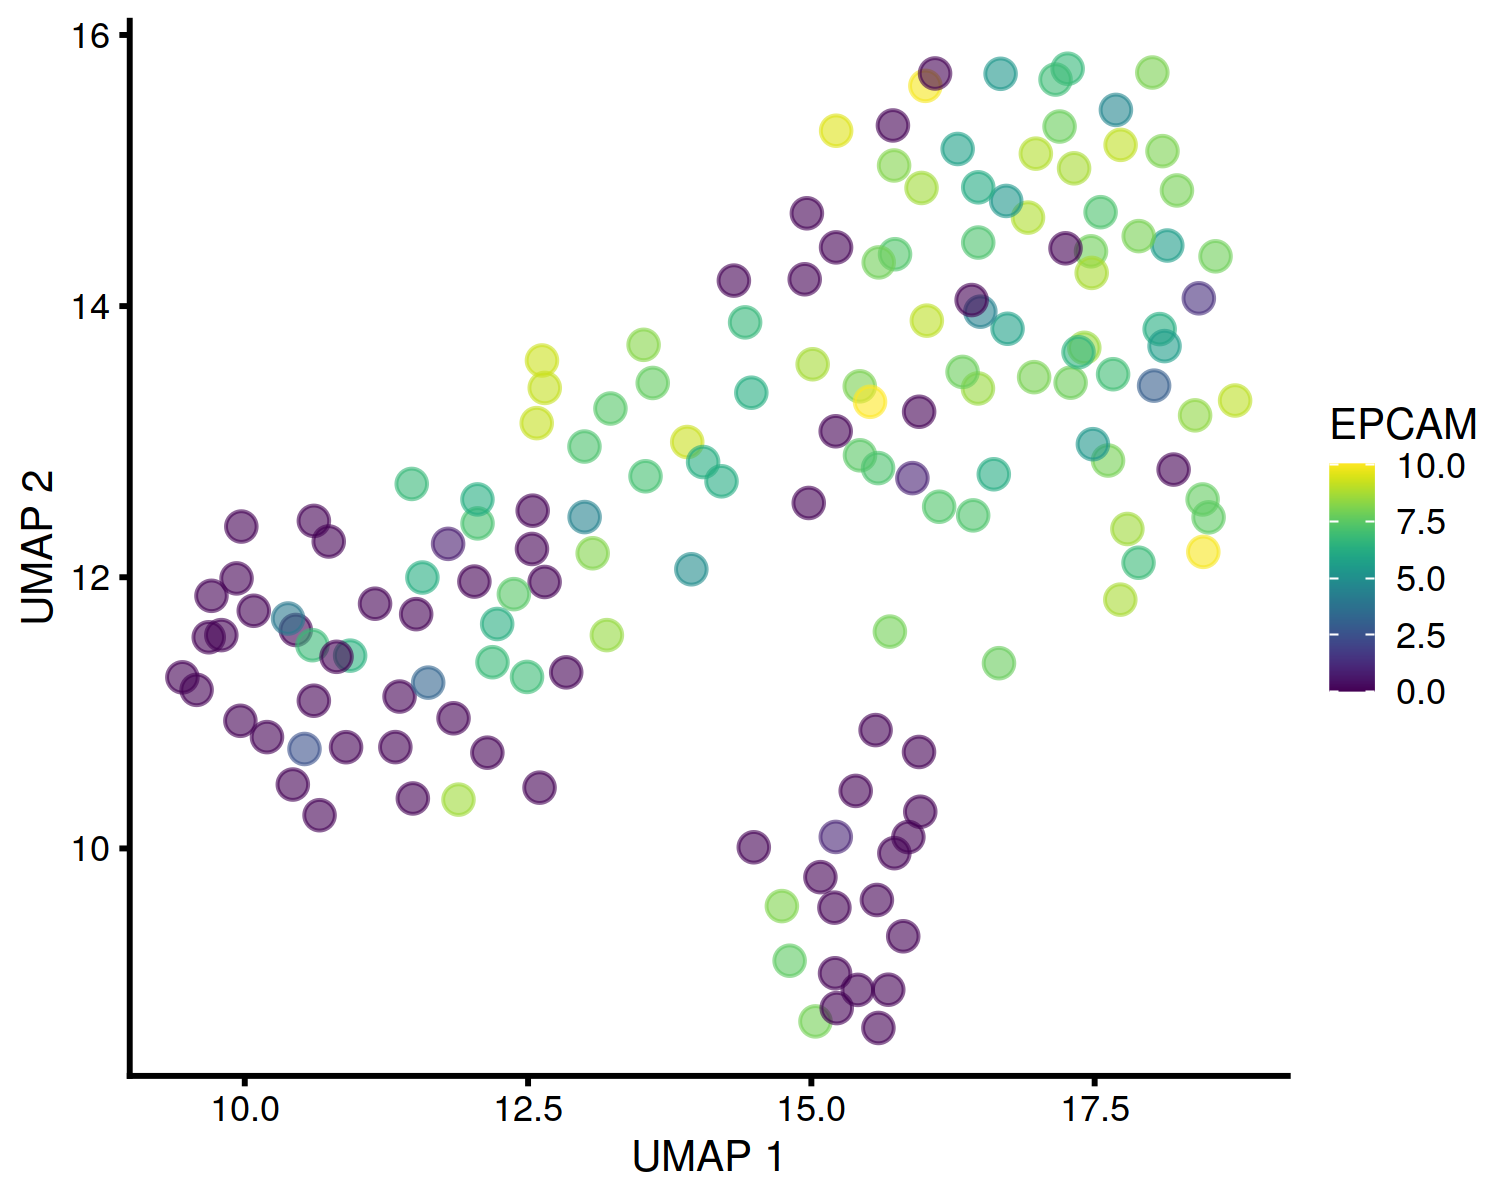

In [44]:
plotUMAP(sce,  colour_by = 'EPCAM', point_size = 3)

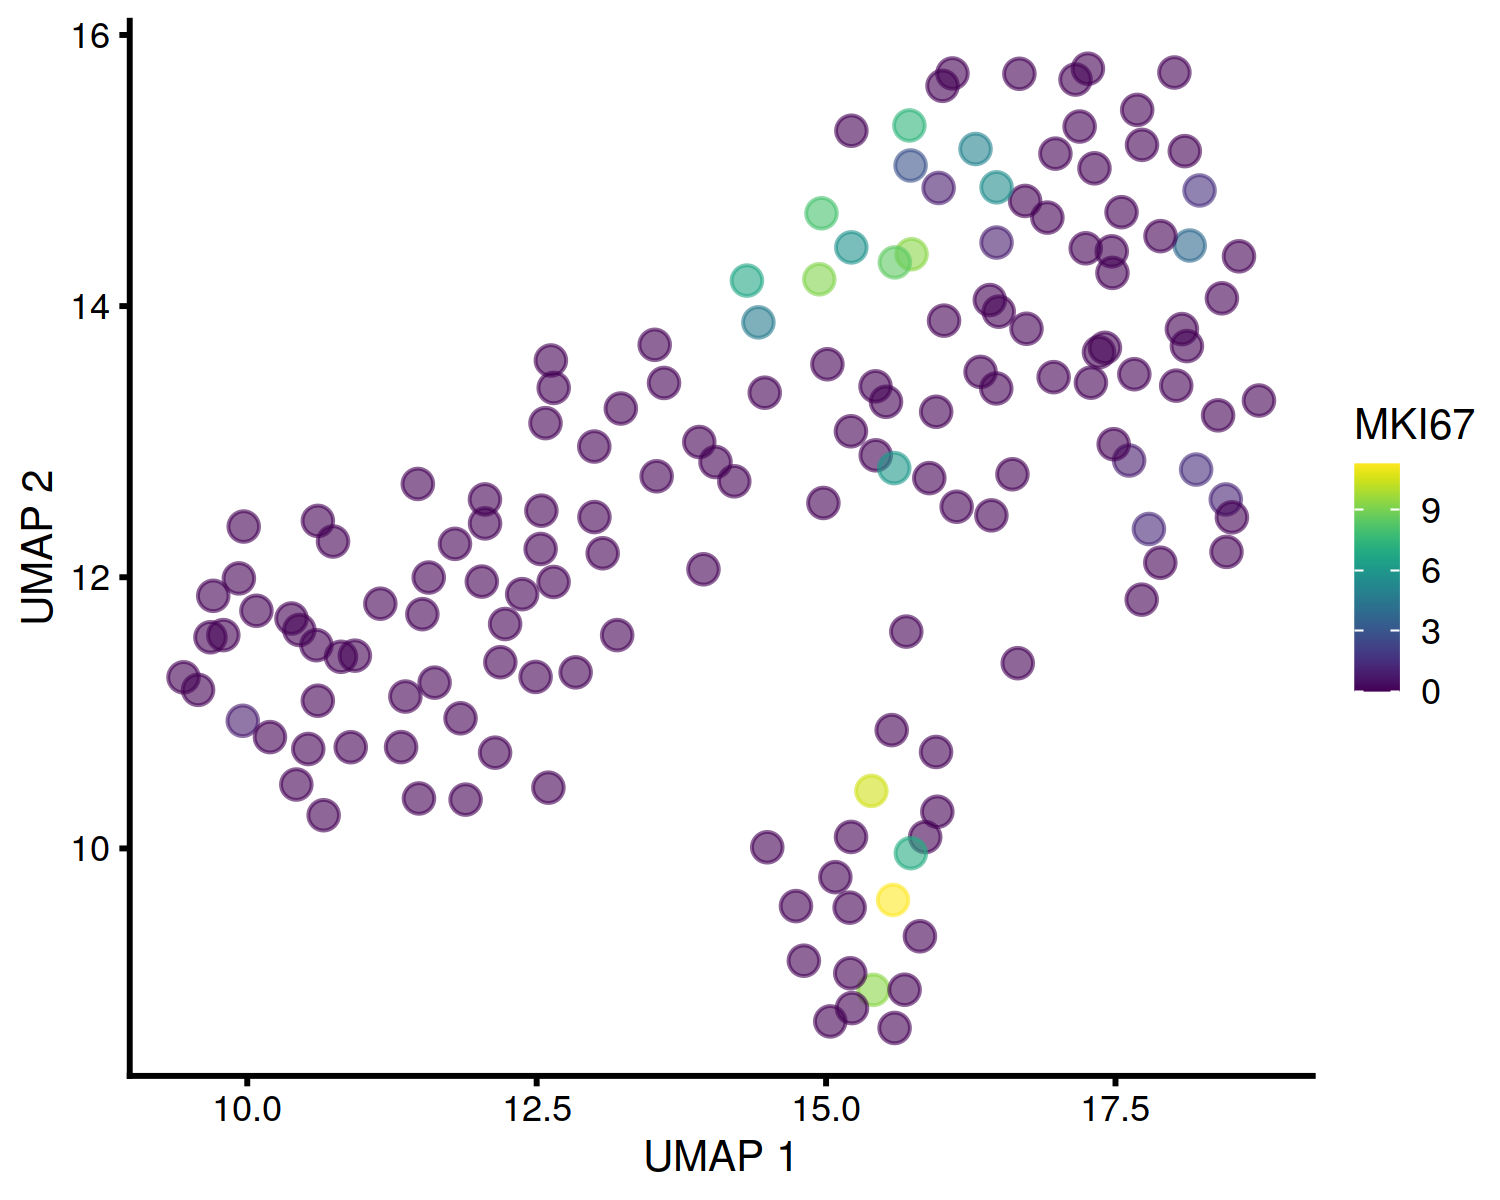

In [49]:
plotUMAP(sce,  colour_by = 'MKI67', point_size = 3)

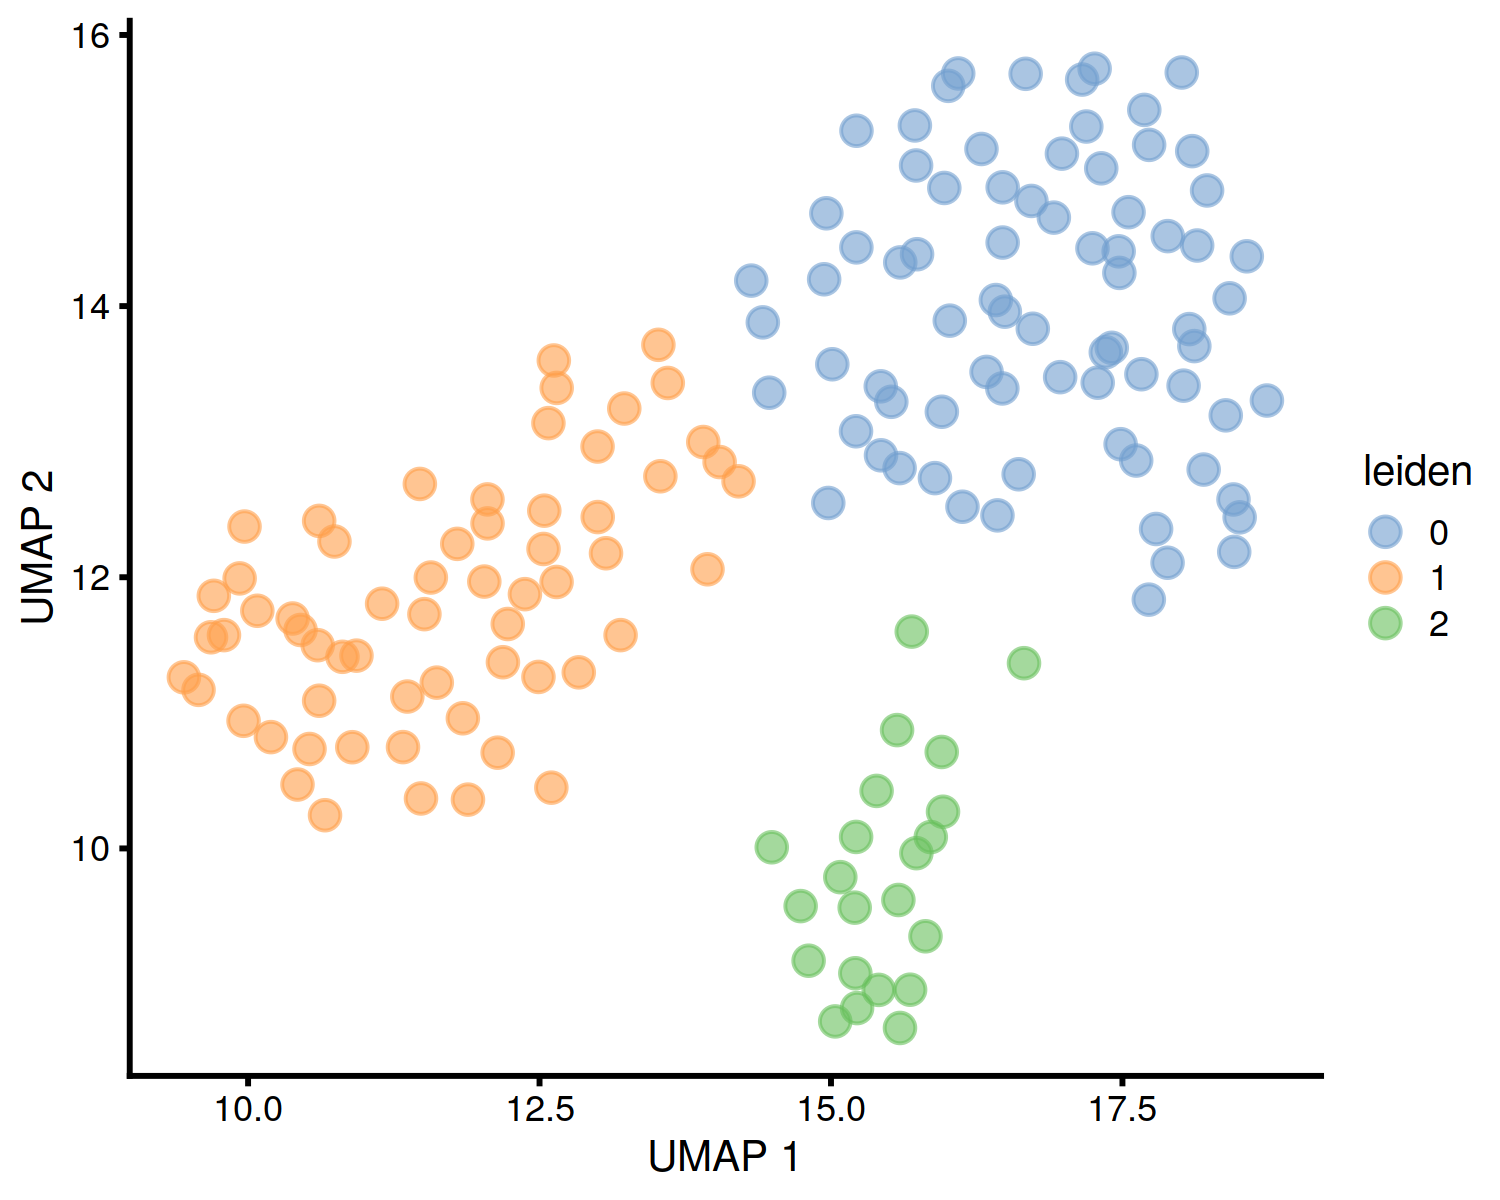

In [34]:
options(repr.plot.width =5, repr.plot.height = 4, repr.plot.res = 300)
plotUMAP(sce,  colour_by = 'leiden', point_size = 3)

In [35]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- findMarkers(sce, groups = sce$leiden, lfc = 1, direction = 'up', subset.row = keep)

In [37]:
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 30),]
})

In [39]:
openxlsx::write.xlsx(top_markers, "./out/TopMarkers_tumorcell_leiden0.6.xlsx")

In [48]:
saveRDS(sce, file = "../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_tumor_D1220.rds")